# Import Libraries

In [6]:
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Autoencoder Architecture
Below is an example autoencoder designed for grayscale images of shape (N, 1, H, W). If your data has 3 channels (e.g. RGB), just update the in_channels from 1 to 3 in the encoder, and similarly adjust the decoder layers.

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # input: (N, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # output: (N, 16, 14, 14)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # output: (N, 32, 7, 7)
        )
        # DECODER
        # Upsamples back to the original shape using ConvTranspose2d.
        self.decoder = nn.Sequential(
            # input: (N, 32, 7, 7)
            nn.ConvTranspose2d(in_channels=32, out_channels=16, 
                               kernel_size=3, stride=2, 
                               padding=1, output_padding=1),
            nn.ReLU(),  # output: (N, 16, 14, 14)
            
            nn.ConvTranspose2d(in_channels=16, out_channels=1, 
                               kernel_size=3, stride=2, 
                               padding=1, output_padding=1),
            nn.Sigmoid()  # output: (N, 1, 28, 28)
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'mps'
model = Autoencoder().to(device)

In [35]:
transform = transforms.ToTensor()

# Use the local MNIST data in ./data/MNIST/raw
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
val_dataset   = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


Train samples: 60000
Validation samples: 10000


# Training Setup

In [36]:
# Loss and optimizer
criterion = nn.MSELoss()  # you can also use BCELoss if preferred
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# Start Training

In [37]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)  # Move images to device
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/1], Loss: 0.0144


# Visualization

In [38]:
import matplotlib.pyplot as plt

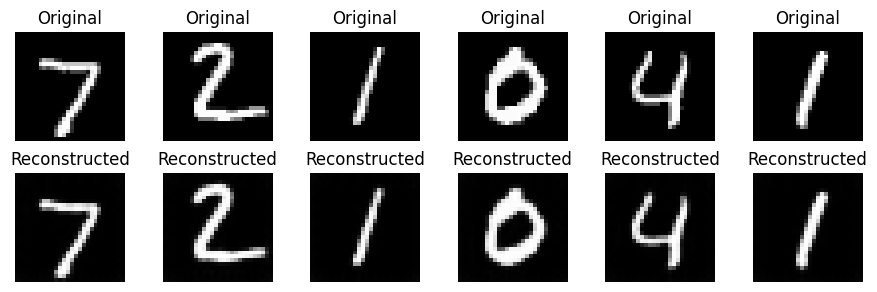

In [39]:
# Visualize some reconstructions on the validation set
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.to(device)
    reconstructions = model(images)

# Move tensors to CPU for visualization
images = images.cpu()
reconstructions = reconstructions.cpu()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for i in range(6):
    # Original images
    axes[0, i].imshow(images[i][0], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructions[i][0], cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()